# Imports

In [180]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


# Data Loading

In [181]:
# from torch.utils.data import Dataset

# class imageDataset(Dataset):
#     #Subclass datasets in order to create a custom one that i dont have to load everything in till im ready
    
#     #All neeccesary methods to implement: Inits it with data
#     def __init__(self, folder_path):
#         self.data = #Stuff from folder path

#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         #Gets the item at idx in form (data, target label) or (X, Y)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()]
)

data_dir = "data/cloud_data" 
dataset = datasets.ImageFolder(root=data_dir, transform=transforms) #Note. Add a transforms=transforms

train_data, test_data, val_data = random_split(dataset, [0.75, .15, .10])

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True) #prolly dont have to shuffle these 2 but might as well

human_labels = ["Altocumulus", "Altostratus", "Cumulonimbus","Cirrocumulus", "Cirrus", "Cirrostratus", "Contrail", "Cumulus",
                 "Nimbus", "Stratocumulus", "Stratus" ] #human readable labels

In [183]:
print(type(dataset))

<class 'torchvision.datasets.folder.ImageFolder'>


In [184]:
for data in train_loader:
    # print(torch.squeeze(data[0][0]).shape) #Data appears to be from 0 to 1
    img = transforms.ToPILImage()(torch.squeeze(data[0][0]))
    
    img.show()
    break


# Basic CNN (no transfer learning)

In [185]:
class convNet(nn.Module):
    def __init__(self):
        super().__init__()
        #nn.conv2d -> in_channels, out_channels, kernel_size
        #Stride defaults to 1
        #Halves on wxh which is done 2x.
        self.all_pooling = nn.MaxPool2d(2, 2)

        #After this: 256-4 -> 252
        self.conv1 = nn.Conv2d(3, 6, 3) #Conv layer 1. Padding is 0

        #Decreases by another 4 
        self.conv2 = nn.Conv2d(6, 16, 3)

        self.conv3 = nn.Conv2d(16, 32, 5)

        self.conv4 = nn.Conv2d(32, 64, 5)
        self.conv_layers = [self.conv1, self.conv2, self.conv3] #Put all conv layers and fcs into a list for ease of iteration through later?

        self.flatten = nn.Flatten()
        
        flattened_size = 26912
        self.fc1 = nn.Linear(flattened_size, 120)
        self.fc2 = nn.Linear(120, 180)
        self.fcs = [self.fc1, self.fc2]
        self.final_fc = nn.Linear(180, 11)


    def forward(self, x):
        for conv_layer in self.conv_layers:
            x = self.all_pooling(F.relu(conv_layer(x)))
        # x = self.all_pooling(F.relu(self.conv1(x)))
        # x = self.all_pooling(F.relu(self.conv2(x)))    
        x = self.flatten(x)

        # print(x.shape)

        for fc in self.fcs:
            x = F.relu(fc(x))
        x = self.final_fc(x)

        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x)) 
        
        #UGH I was probably supposed to softmax them
        return x

In [186]:
model  = convNet()
for data in train_loader:
    model.forward(data[0])
    break


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x20000 and 26912x120)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #Multi class loss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)



In [ ]:
def eval_model(model, test_loader):
    running_acc = 0

    for inputs, labels in test_loader:
        outputs = model(inputs)
        running_acc += torch.sum(torch.argmax(outputs, dim = 1) == labels) / len(labels)

    return running_acc / len(test_loader)

In [202]:
def train(model,train_loader, test_loader, criterion, optimizer, model_fp, num_epochs=10, batches_to_print=20):
    print("starting training")
    best_acc = 0

    for epoch in range(num_epochs): 

        running_loss = 0
        running_acc = 0
        
        for i, data in enumerate(train_loader):
            inputs, labels = data

            model.train() #if we ever decide to batchnorm later. jujst tells it that we're in training mode rn
            optimizer.zero_grad() #zero grad
            
            outputs = model(inputs) #fd it

            acc = torch.sum(torch.argmax(outputs, dim = 1) == labels) / len(labels)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_acc += acc.item()
            running_loss += loss.item()

            if i % batches_to_print == batches_to_print - 1:    # print every 20 batches
                print(f'Epoch {epoch + 1} batcj {i + 1} loss: {running_loss / batches_to_print:.3f} acc {running_acc / batches_to_print:.3f}')
                running_acc = 0
                running_loss = 0 

        if test_loader is not None:
            test_acc = eval_model(model, test_loader)
            print(f"tested at {test_acc}")
            if test_acc > best_acc and epoch >= 3 and (model_fp != None):
                best_acc = test_acc
                print(f"Saving model at {model_fp}")
                torch.save(model.state_dict(), model_fp)


    print(f'Finished Training. Model saved has acc {best_acc}') 

In [ ]:
#what the f*** how is it 93 acc when i just threw some random stuff together???
print(eval_model(model, test_loader))

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "clouds_1.pt")

# Resnet

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.02),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.05), 
    # transforms.Normalize([0.485, 0.456,0.406],
    #                     [0.229, 0.224, 0.225]), 
])

resnet_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456,0.406],
                         [0.229, 0.224, 0.225]), 
                         ]
)
data_dir = "data/cloud_data" 
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms) #Note. Add a transforms=transforms

train_data, test_data, val_data = random_split(dataset, [0.75, .15, .10])

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True) #prolly dont have to shuffle these 2 but might as well

human_labels = ["Altocumulus", "Altostratus", "Cumulonimbus","Cirrocumulus", "Cirrus", "Cirrostratus", "Contrail", "Cumulus",
                 "Nimbus", "Stratocumulus", "Stratus" ] #human readable labels

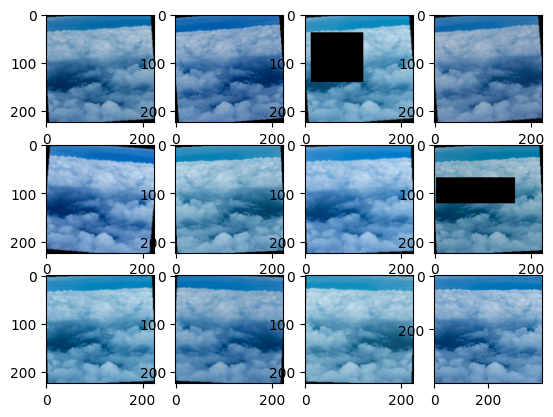

In [237]:
#Show some of the images before/after transform to make sure its not tweaking
from PIL import Image

test_img = Image.open("data/cloud_data/Ac/Ac-N012.jpg")

fig, axes = plt.subplots(3, 4)

for ax in axes.flat[1:]:
    ax.imshow(torch.permute(train_transforms(test_img), [1, 2, 0]))

axes.flat[0].imshow(torch.permute(train_transforms(test_img), [1, 2, 0]))


plt.imshow(test_img)

In [ ]:
from torchvision import models


resnet = models.resnet50(pretrained=True) #gonna start small ish so my computer doesnt blow up

for param in resnet.parameters():
    param.requires_grad = False

for param in resnet.layer4.parameters():
    param.requires_grad = True

resnet.fc = nn.Linear(resnet.fc.in_features, 11)


In [208]:

for param in resnet.layer2.parameters():
    param.requires_grad = True

In [ ]:

resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam([*resnet.fc.parameters()], lr=1e-3) 
#, *resnet.layer4.parameters(), *resnet.layer3.parameters(), *resnet.layer2.parameters()
epochs = 20 
train(resnet, train_loader, test_loader, criterion=resnet_criterion, optimizer=resnet_optimizer, model_fp= "resnet_attempt3.pth", num_epochs = 10)

starting training
Epoch 1 batcj 20 loss: 1.892 acc 0.353
Epoch 1 batcj 40 loss: 1.687 acc 0.409
Epoch 1 batcj 60 loss: 1.749 acc 0.368
tested at 0.3985272943973541
Epoch 2 batcj 20 loss: 1.569 acc 0.439
Epoch 2 batcj 40 loss: 1.683 acc 0.392
Epoch 2 batcj 60 loss: 1.702 acc 0.416
tested at 0.4063397943973541
Epoch 3 batcj 20 loss: 1.649 acc 0.444
Epoch 3 batcj 40 loss: 1.578 acc 0.430
Epoch 3 batcj 60 loss: 1.678 acc 0.413
tested at 0.4172952473163605
Epoch 4 batcj 20 loss: 1.542 acc 0.480
Epoch 4 batcj 40 loss: 1.597 acc 0.448
Epoch 4 batcj 60 loss: 1.526 acc 0.460
tested at 0.4230423867702484
Saving model at resnet_attempt2.pth
Epoch 5 batcj 20 loss: 1.485 acc 0.494
Epoch 5 batcj 40 loss: 1.518 acc 0.461
Epoch 5 batcj 60 loss: 1.543 acc 0.463
tested at 0.4630926847457886
Saving model at resnet_attempt2.pth
Epoch 6 batcj 20 loss: 1.474 acc 0.478
Epoch 6 batcj 40 loss: 1.466 acc 0.508
Epoch 6 batcj 60 loss: 1.642 acc 0.430
tested at 0.39798852801322937
Epoch 7 batcj 20 loss: 1.530 acc 

KeyboardInterrupt: 

In [219]:
clean_data = datasets.ImageFolder(data_dir, transform=resnet_transforms)
test, garbage = random_split(dataset, [0.15, .85])

clean_data = DataLoader(test, shuffle=True)


print(eval_model(resnet, clean_data))


tensor(0.0942)
